# Rs 4 0 1C_ Feldman Cousins
Produces an interval on the mean signal in a number counting experiment with known background using the
Feldman-Cousins technique.

Using the RooStats FeldmanCousins tool with 200 bins
it takes 1 min and the interval is [0.2625, 10.6125]
with a step size of 0.075.
The interval in Feldman & Cousins's original paper is [.29, 10.81] Phys.Rev.D57:3873-3889,1998.




**Author:** Kyle Cranmer  
<i><small>This notebook tutorial was automatically generated with <a href= "https://github.com/root-project/root/blob/master/documentation/doxygen/converttonotebook.py">ROOTBOOK-izer</a> from the macro found in the ROOT repository  on Thursday, August 29, 2019 at 03:15 AM.</small></i>

In [1]:
%%cpp -d
#include "RooGlobalFunc.h"
#include "RooStats/ConfInterval.h"
#include "RooStats/PointSetInterval.h"
#include "RooStats/ConfidenceBelt.h"
#include "RooStats/FeldmanCousins.h"
#include "RooStats/ModelConfig.h"

#include "RooWorkspace.h"
#include "RooDataSet.h"
#include "RooRealVar.h"
#include "RooConstVar.h"
#include "RooAddition.h"

#include "RooDataHist.h"

#include "RooPoisson.h"
#include "RooPlot.h"

#include "TCanvas.h"
#include "TTree.h"
#include "TH1F.h"
#include "TMarker.h"
#include "TStopwatch.h"

#include <iostream>

Use this order for safety on library loading

In [2]:
%%cpp -d
// This is a workaround to make sure the namespace is used inside functions
using namespace RooFit;
using namespace RooStats;

To time the macro... about 30 s

In [3]:
TStopwatch t;
t.Start();

Make a simple model

In [4]:
RooRealVar x("x", "", 1, 0, 50);
RooRealVar mu("mu", "", 2.5, 0, 15); // with a limit on mu>=0
RooConstVar b("b", "", 3.);
RooAddition mean("mean", "", RooArgList(mu, b));
RooPoisson pois("pois", "", x, mean);
RooArgSet parameters(mu);


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



Create a toy dataset

In [5]:
RooDataSet *data = pois.generate(RooArgSet(x), 1);
data->Print("v");

TCanvas *dataCanvas = new TCanvas("dataCanvas");
RooPlot *frame = x.frame();
data->plotOn(frame);
frame->Draw();
dataCanvas->Update();

RooWorkspace *w = new RooWorkspace();
ModelConfig modelConfig("poissonProblem", w);
modelConfig.SetPdf(pois);
modelConfig.SetParametersOfInterest(parameters);
modelConfig.SetObservables(RooArgSet(x));
w->Print();

DataStore poisData (Generated From )
  Contains 1 entries
  Observables: 
    1)  x = 7  L(0 - 50)  ""

RooWorkspace()  contents

variables
---------
(mu,x)

p.d.f.s
-------
RooPoisson::pois[ x=x mean=mean ] = 0.0224772

functions
--------
RooAddition::mean[ mu + b ] = 5.5

named sets
----------
poissonProblem_Observables:(x)
poissonProblem_POI:(mu)



////// show use of feldman-cousins

In [6]:
RooStats::FeldmanCousins fc(*data, modelConfig);
fc.SetTestSize(.05); // set size of test
fc.UseAdaptiveSampling(true);
fc.FluctuateNumDataEntries(false); // number counting analysis: dataset always has 1 entry with N events observed
fc.SetNBins(100);                  // number of points to test per parameter

Use the feldman-cousins tool

In [7]:
PointSetInterval *interval = (PointSetInterval *)fc.GetInterval();


=== Using the following for poissonProblem ===
Observables:             RooArgSet:: = (x)
Parameters of Interest:  RooArgSet:: = (mu)
PDF:                     RooPoisson::pois[ x=x mean=mean ] = 0.0224772

FeldmanCousins: ntoys per point: adaptive
FeldmanCousins: nEvents per toy will not fluctuate, will always be 1
FeldmanCousins: Model has no nuisance parameters
FeldmanCousins: # points to test = 100
NeymanConstruction: Prog: 1/100 total MC = 240 this test stat = 1.83324
 mu=0.075 [-1e+30, 1.08573]  in interval = 0

NeymanConstruction: Prog: 2/100 total MC = 80 this test stat = 1.64984
 mu=0.225 [-1e+30, 0.949959]  in interval = 0

NeymanConstruction: Prog: 3/100 total MC = 80 this test stat = 1.4816
 mu=0.375 [-1e+30, 0.827185]  in interval = 0

NeymanConstruction: Prog: 4/100 total MC = 240 this test stat = 1.32721
 mu=0.525 [-1e+30, 1.32721]  in interval = 1

NeymanConstruction: Prog: 5/100 total MC = 80 this test stat = 1.1855
 mu=0.675 [-1e+30, 2.73604]  in interval = 1

NeymanC

Make a canvas for plots

In [8]:
TCanvas *intervalCanvas = new TCanvas("intervalCanvas");

std::cout << "is this point in the interval? " << interval->IsInInterval(parameters) << std::endl;

std::cout << "interval is [" << interval->LowerLimit(mu) << ", " << interval->UpperLimit(mu) << "]" << endl;

is this point in the interval? 0
interval is [0.525, 10.575]


Using 200 bins it takes 1 min and the answer is
 interval is [0.2625, 10.6125] with a step size of .075
 The interval in Feldman & Cousins's original paper is [.29, 10.81]
  Phys.Rev.D57:3873-3889,1998.

No dedicated plotting class yet, so do it by hand:

In [9]:
RooDataHist *parameterScan = (RooDataHist *)fc.GetPointsToScan();
TH1F *hist = (TH1F *)parameterScan->createHistogram("mu", 30);
hist->Draw();

RooArgSet *tmpPoint;

Loop over points to test

In [10]:
for (Int_t i = 0; i < parameterScan->numEntries(); ++i) {
   //    cout << "on parameter point " << i << " out of " << parameterScan->numEntries() << endl;
   // get a parameter point from the list of points to test.
   tmpPoint = (RooArgSet *)parameterScan->get(i)->clone("temp");

   TMarker *mark = new TMarker(tmpPoint->getRealValue("mu"), 1, 25);
   if (interval->IsInInterval(*tmpPoint))
      mark->SetMarkerColor(kBlue);
   else
      mark->SetMarkerColor(kRed);

   mark->Draw("s");
   // delete tmpPoint;
   //    delete mark;
}
t.Stop();
t.Print();

Real time 0:00:04, CP time 3.440


Draw all canvases 

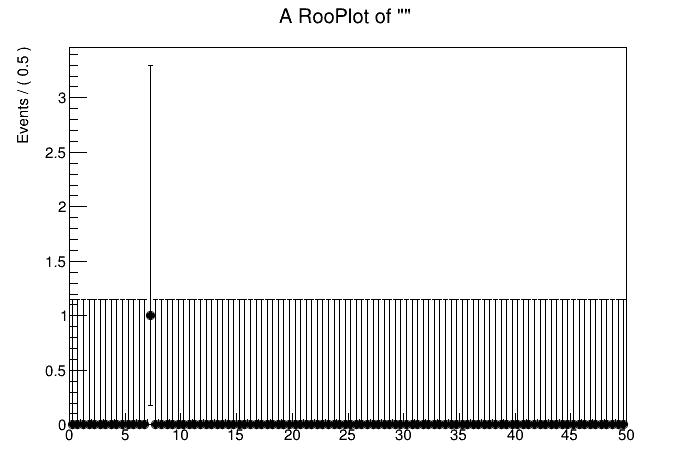

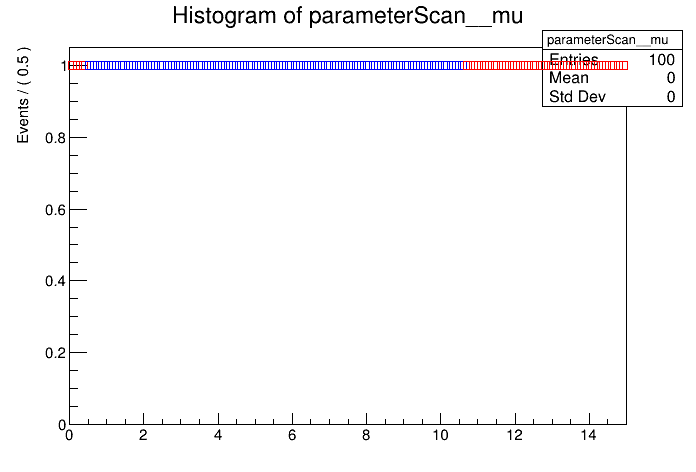

In [11]:
gROOT->GetListOfCanvases()->Draw()